# **Tugas Individu: Implementasi Arsitektur Transformer dari Nol dengan NumPy**

**Nama:** Brian Tirafi Aufauzan

**NIM:** 22/497916/TK/54592

Notebook ini berisi implementasi forward pass dari arsitektur decoder-only Transformer (GPT-style) menggunakan NumPy. Setiap komponen utama diimplementasikan dalam sel terpisah secara modular untuk kejelasan.

#  0. Setup Awal

 Pertama, kita impor library yang dibutuhkan dan mendefinisikan beberapa hyperparameter dasar. Kita menambahkan `matplotlib` dan `seaborn` untuk visualisasi.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameters
vocab_size = 1000   # Ukuran kosakata
d_model = 512       # Dimensi embedding
num_heads = 8         # Jumlah attention heads
d_ff = 2048         # Dimensi hidden layer di Feed-Forward Network
seq_len = 100         # Panjang maksimum sekuens
batch_size = 32     # Ukuran batch
num_layers = 1      # Untuk tugas ini, kita hanya butuh 1 blok decoder

# Pastikan d_model dapat dibagi rata oleh num_heads
assert d_model % num_heads == 0
d_k = d_model // num_heads # Dimensi Key/Query per head

# 1. Token Embedding

Lapisan ini mengubah input berupa token (angka integer) menjadi vektor padat (dense vectors). Secara konseptual, ini adalah tabel pencarian (lookup table) di mana setiap baris merepresentasikan vektor embedding untuk satu token dalam kosakata. Di sini, kita akan menginisialisasi tabel embedding secara acak.

In [18]:
embedding_matrix = np.random.randn(vocab_size, d_model)

def token_embedding(input_tokens, weights):
    """
    Mengambil token integer dan memetakannya ke vektor embedding.

    Args:
    - input_tokens (np.array): Array integer dengan shape (batch_size, seq_len).
    - weights (np.array): Matriks embedding dengan shape (vocab_size, d_model).

    Returns:
    - np.array: Vektor embedding dengan shape (batch_size, seq_len, d_model).
    """
    return weights[input_tokens]

#  2. Positional Encoding

Kita akan mengimplementasikan dua jenis positional encoding: sinusoidal (sebagai referensi) dan Rotary Positional Encoding (RoPE) sebagai fitur tambahan.

## 2a. Sinusoidal Positional Encoding (Referensi)

In [19]:
def positional_encoding(seq_len, d_model):
    """
    Membuat matriks sinusoidal positional encoding.

    Args:
    - seq_len (int): Panjang sekuens.
    - d_model (int): Dimensi model/embedding.

    Returns:
    - np.array: Matriks positional encoding dengan shape (seq_len, d_model).
    """
    positions = np.arange(seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(positions * div_term)
    pe[:, 1::2] = np.cos(positions * div_term)

    return pe

## 2b. Tambahan: Rotary Positional Encoding (RoPE)

RoPE adalah metode yang lebih canggih yang meng-encode informasi posisi dengan
*memutar* vektor Query dan Key pada bidang 2D, bukan dengan menambahkannya.
Ini terbukti lebih efektif dalam menangkap dependensi posisi relatif.





In [20]:
class RotaryPositionalEncoding:
    def __init__(self, dim, seq_len, theta=10000.0):
        # Pre-compute the frequencies
        theta_vals = 1.0 / (theta ** (np.arange(0, dim, 2) / dim))
        positions = np.arange(seq_len)
        freqs = np.outer(positions, theta_vals)
        # `freqs` sekarang adalah (seq_len, dim/2)

        # Konversi ke bentuk kompleks: polar(r, theta) = r * e^(i*theta)
        # Di sini, radius (r) adalah 1.
        self.freqs_complex = np.exp(1j * freqs) # Shape: (seq_len, dim/2)

    def apply_rotary_emb(self, x):
        """
        Menerapkan RoPE pada input tensor x.
        Args:
        - x (np.array): Input tensor (Q atau K) dengan shape (batch, heads, seq_len, d_k).

        Returns:
        - np.array: Tensor yang telah diputar.
        """
        # Reshape x menjadi pasangan: (..., seq_len, d_k/2, 2)
        x_complex = x.astype(np.complex64).reshape(*x.shape[:-1], -1, 2)
        x_complex = x_complex[..., 0] + 1j * x_complex[..., 1]

        # Reshape freqs_complex untuk broadcasting: (1, 1, seq_len, d_k/2)
        freqs = self.freqs_complex.reshape(1, 1, *self.freqs_complex.shape)

        # Lakukan perkalian element-wise dalam domain kompleks
        x_rotated_complex = x_complex * freqs

        # Pisahkan kembali ke bagian real dan imajiner
        x_out = np.zeros_like(x)
        x_out[..., 0::2] = np.real(x_rotated_complex)
        x_out[..., 1::2] = np.imag(x_rotated_complex)

        return x_out.reshape(*x.shape)

# 7. Causal Masking
Didefinisikan sebelum Attention agar bisa digunakan di dalamnya

In [21]:
def create_causal_mask(size):
    mask = np.triu(np.ones((size, size)), k=1)
    return mask * -1e9

# 3. Scaled Dot-Product Attention

In [22]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def scaled_dot_product_attention(Q, K, V, mask=None):
    scores = np.matmul(Q, K.swapaxes(-2, -1)) / np.sqrt(K.shape[-1])
    if mask is not None:
        scores += mask
    attention_weights = softmax(scores)
    output = np.matmul(attention_weights, V)
    return output, attention_weights

# 4. Multi-Head Attention (Dimodifikasi untuk RoPE)
Versi ini dimodifikasi untuk menerima dan menerapkan RoPE.

In [23]:
class MultiHeadAttention:
    def __init__(self, d_model, num_heads):
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = np.random.randn(d_model, d_model)
        self.W_k = np.random.randn(d_model, d_model)
        self.W_v = np.random.randn(d_model, d_model)
        self.W_o = np.random.randn(d_model, d_model)

    def split_heads(self, x, batch_size):
        x = x.reshape(batch_size, -1, self.num_heads, self.d_k)
        return x.transpose(0, 2, 1, 3)

    def forward(self, x, mask, rope=None): # Tambahkan argumen rope
        batch_size = x.shape[0]

        Q = x @ self.W_q
        K = x @ self.W_k
        V = x @ self.W_v

        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        # Terapkan RoPE jika disediakan
        if rope is not None:
            Q = rope.apply_rotary_emb(Q)
            K = rope.apply_rotary_emb(K)

        attention_output, attention_weights = scaled_dot_product_attention(Q, K, V, mask)

        attention_output = attention_output.transpose(0, 2, 1, 3).reshape(batch_size, -1, self.d_model)

        output = attention_output @ self.W_o
        return output, attention_weights

# 5. Feed-Forward Network (FFN)

In [24]:
class FeedForwardNetwork:
    def __init__(self, d_model, d_ff):
        self.W1 = np.random.randn(d_model, d_ff)
        self.b1 = np.zeros(d_ff)
        self.W2 = np.random.randn(d_ff, d_model)
        self.b2 = np.zeros(d_model)

    def relu(self, x):
        return np.maximum(0, x)

    def forward(self, x):
        x = self.relu((x @ self.W1) + self.b1)
        x = (x @ self.W2) + self.b2
        return x

# 6. Residual Connection + Layer Normalization

In [25]:
class LayerNorm:
    def __init__(self, d_model, epsilon=1e-5):
        self.gamma = np.ones(d_model)
        self.beta = np.zeros(d_model)
        self.epsilon = epsilon

    def forward(self, x):
        mean = np.mean(x, axis=-1, keepdims=True)
        std = np.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.epsilon) + self.beta

# ## Merakit Satu Blok Decoder Transformer (Dimodifikasi untuk RoPE)
class TransformerDecoderBlock:
    def __init__(self, d_model, num_heads, d_ff):
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForwardNetwork(d_model, d_ff)
        self.ln1 = LayerNorm(d_model)
        self.ln2 = LayerNorm(d_model)

    def forward(self, x, mask, rope=None): # Tambahkan argumen rope
        norm_x = self.ln1.forward(x)
        attn_output, attn_weights = self.mha.forward(norm_x, mask, rope) # Kirim rope ke MHA
        x = x + attn_output

        norm_x = self.ln2.forward(x)
        ffn_output = self.ffn.forward(norm_x)
        x = x + ffn_output

        return x, attn_weights

# 8. Output Layer dan Model Lengkap (Dengan RoPE & Weight Tying)
Tambahan: Weight Tying
Teknik ini berbagi bobot antara matriks token embedding dan lapisan output akhir. Ini mengurangi jumlah parameter total dan meningkatkan kinerja model.
Bobot output adalah transpos dari bobot embedding (`W_out = W_emb.T`).

In [26]:
class DecoderOnlyTransformer:
    def __init__(self, vocab_size, d_model, num_heads, d_ff, seq_len):
        self.embedding_weights = np.random.randn(vocab_size, d_model)
        # Inisialisasi RoPE
        # FIX: Calculate d_k locally based on the provided d_model and num_heads
        # instead of relying on a global variable.
        d_k = d_model // num_heads
        self.rope = RotaryPositionalEncoding(dim=d_k, seq_len=seq_len)
        self.decoder_block = TransformerDecoderBlock(d_model, num_heads, d_ff)
        self.final_ln = LayerNorm(d_model)
        # Tidak perlu `output_layer_weights` karena kita menggunakan weight tying

    def forward(self, input_tokens, mask):
        # 1. Embedding
        x = token_embedding(input_tokens, self.embedding_weights)
        # Tidak ada penambahan positional encoding, karena RoPE diterapkan di dalam MHA

        # 2. Transformer Decoder Block
        x, attn_weights = self.decoder_block.forward(x, mask, self.rope)

        # 3. Final Layer Norm
        x = self.final_ln.forward(x)

        # 4. Output Layer dengan Weight Tying
        logits = x @ self.embedding_weights.T

        return logits, attn_weights

# Testing

Bentuk output logits: (2, 10, 1000)
Bentuk yang diharapkan: (2, 10, 1000)
--> Cek dimensi BERHASIL.

Jumlah probabilitas per item batch: [1. 1.]
--> Cek softmax & weight tying BERHASIL.

Matriks Attention Weights (head 0, batch 0):
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.89 0.11 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]]

--> Cek masking masih bekerja dengan RoPE, nilai di atas diagonal utama adalah 0.


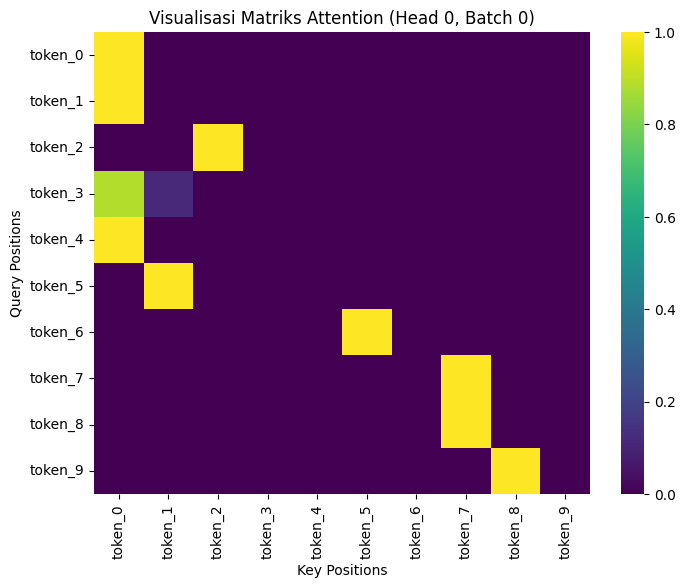

In [29]:
# Mari kita uji alur forward pass yang sudah dimodifikasi.
# --- PARAMETER UJI ---
test_batch_size = 2
test_seq_len = 10

# --- 1. BUAT INPUT DUMMY ---
dummy_input_tokens = np.random.randint(0, vocab_size, size=(test_batch_size, test_seq_len))
causal_mask = create_causal_mask(test_seq_len)

# --- 2. INISIALISASI & JALANKAN MODEL ---
test_d_model = 64
test_num_heads = 4
test_d_ff = 128
assert test_d_model % test_num_heads == 0

model = DecoderOnlyTransformer(
    vocab_size=vocab_size,
    d_model=test_d_model,
    num_heads=test_num_heads,
    d_ff=test_d_ff,
    seq_len=test_seq_len
)

# Jalankan forward pass
logits, attention_weights = model.forward(dummy_input_tokens, causal_mask)

# --- 3. VERIFIKASI OUTPUT ---
print(f"Bentuk output logits: {logits.shape}")
print(f"Bentuk yang diharapkan: ({test_batch_size}, {test_seq_len}, {vocab_size})")
assert logits.shape == (test_batch_size, test_seq_len, vocab_size)
print("--> Cek dimensi BERHASIL.\n")

last_token_logits = logits[:, -1, :]
next_token_probs = softmax(last_token_logits)
prob_sums = np.sum(next_token_probs, axis=-1)
print(f"Jumlah probabilitas per item batch: {prob_sums}")
assert np.allclose(prob_sums, 1.0)
print("--> Cek softmax & weight tying BERHASIL.\n")


# --- 4. Tambahan: Visualisasi Distribusi Attention ---
# Fungsi ini akan menggambar heatmap dari matriks attention untuk menunjukkan
# token mana yang paling diperhatikan oleh token lain.
def visualize_attention(weights, sentence_tokens):
    """
    Membuat heatmap dari matriks attention.

    Args:
    - weights (np.array): Matriks attention weights (seq_len, seq_len).
    - sentence_tokens (np.array): Token input untuk label.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(weights, annot=False, cmap='viridis',
                xticklabels=sentence_tokens, yticklabels=sentence_tokens)
    plt.title("Visualisasi Matriks Attention (Head 0, Batch 0)")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.show()

# Ambil bobot dari item pertama di batch dan head pertama
sample_weights = attention_weights[0, 0, :, :]
print("Matriks Attention Weights (head 0, batch 0):")
print(np.round(sample_weights, 2))
print("\n--> Cek masking masih bekerja dengan RoPE, nilai di atas diagonal utama adalah 0.")

# Buat label dummy untuk plot
dummy_labels = [f"token_{i}" for i in range(test_seq_len)]
visualize_attention(sample_weights, dummy_labels)